In [39]:
import os 
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [14]:
%matplotlib inline
import pandas as pd

In [2]:
df = pd.read_parquet("user_books_all.parquet")
print(df.shape)
df.head()

(10328524, 17)


,reader,inventary_id,barcode,datetime_start,datetime_end,state,doc_id,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id
0,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6545,5190,Семенова Мария Васильевна,Год Людоеда,Москва ; Санкт-Петербург,АСТ ; Азбука,2000,None,Художественная литература,84(2Рос)6,None,03:0000005767
1,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6548,5190,Семенова Мария Васильевна,Год Людоеда,Москва ; Санкт-Петербург,АСТ ; Азбука,2000,None,Художественная литература,84(2Рос)6,None,03:0000005767
2,163,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-13 15:00:00,6548,5190,Семенова Мария Васильевна,Год Людоеда,Москва ; Санкт-Петербург,АСТ ; Азбука,2000,None,Художественная литература,84(2Рос)6,None,03:0000005767
3,179,03:0000005767,381000177719,2018-04-13 15:00:00,2018-04-16 15:00:00,6548,5190,Семенова Мария Васильевна,Год Людоеда,Москва ; Санкт-Петербург,АСТ ; Азбука,2000,None,Художественная литература,84(2Рос)6,None,03:0000005767
4,179,03:0000005761,381000196420,2018-04-13 15:00:00,2018-04-16 15:00:00,6548,5185,None,Сказки о солдате,Москва,Эгмонт Россия,1999,Библиотека русской сказки,Художественная литература ; Фольклор России,82.3(2Рос),None,03:0000005761


In [25]:
df.reader.unique().shape

(450509,)

In [26]:
df.reader.max()

566212

In [31]:
df.doc_id.unique().shape

(624900,)

In [23]:
df['topic'].value_counts()

Художественная литература                                                                                                              4578353
Литература для детей и юношества                                                                                                        599872
Художественная литература ; Литература для детей и юношества                                                                            376356
История России                                                                                                                          339269
Издания универсального содержания                                                                                                       283673
                                                                                                                                        ...   
Рукоделие ; Технология строительного производства                                                                                            1

In [43]:
df.title.value_counts()

Наука и жизнь                                                  76076
Вокруг света                                                   75003
Дилетант                                                       67074
Лиза                                                           61782
Собрание сочинений                                             51736
                                                               ...  
Памятники литературы Древней Руси: вторая половина XVI века        1
Ответы молодым                                                     1
Защита прав в уголовном процессе: Советы адвоката                  1
Наше Отечество: Опыт политической истории                          1
Пятеро: Роман и пять рассказов о старой Одессе                     1
Name: title, Length: 287081, dtype: int64

In [3]:
df = df.drop(columns=['state'])

In [4]:
df = df.drop_duplicates()

In [5]:
df.shape

(10241621, 16)

In [19]:
df.doc_id.value_counts()[:100000]

438933     25972
439155     19754
1270341    13891
416677     13715
445127     12389
           ...  
298050        19
368469        19
1060576       19
24980         19
442040        19
Name: doc_id, Length: 100000, dtype: int64

In [24]:
import os
import time
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
from scipy.sparse import coo_matrix
from torch.optim import Adam

In [82]:
doc_mapping = {doc_id:i for i, doc_id in enumerate(df.doc_id.unique().tolist())}
user_mapping = {user_id:i for i, user_id in enumerate(df.reader.unique().tolist())}
back_doc_mapping = {i:doc_id for i, doc_id in enumerate(df.doc_id.unique().tolist())}
back_user_mapping = {i:user_id for i, user_id in enumerate(df.reader.unique().tolist())}

In [146]:
pos_item_user_data = df[["doc_id", "reader"]]
pos_item_user_data["score"] = 1

<ipython-input-146-f611835acec4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_item_user_data["score"] = 1


In [147]:
pos_item_user_data = pos_item_user_data.groupby(["reader", "doc_id"]) \
    .agg(np.sum)

pos_item_user_data.head()

score
reader doc_id       
163    1           1
       6           4
       5190        1
       7812        1
       10652       1

In [148]:
import random
import itertools
from tqdm import tqdm_notebook

In [149]:
pos_item_user_data = pos_item_user_data.reset_index()
pos_item_user_data["score"] = np.log1p(pos_item_user_data["score"])

In [201]:
pos_item_user_data["score"] = 1

In [151]:
item_ids = item_user_data.doc_id.unique().tolist()
user_ids = item_user_data.reader.unique().tolist()

In [212]:
user_reading = df \
    .groupby("reader") \
    [['doc_id']] \
    .count() \
    .to_dict()['doc_id']

In [214]:
random_neg = list(itertools.chain.from_iterable(
    [(user_id, item_id) for item_id in random.choices(item_ids, k=user_reading[user_id] * 5)] 
    for user_id in tqdm_notebook(user_ids)))

<ipython-input-214-f00f829087c6>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm_notebook(user_ids)))


In [215]:
neg_item_user = pd.DataFrame(random_neg, columns=["reader", "doc_id"])
neg_item_user["score"] = 0

In [218]:
item_user_data = pd.concat([pos_item_user_data, neg_item_user])

In [219]:
item_user_data["iid"] = item_user_data["doc_id"].map(doc_mapping)
item_user_data["uid"] = item_user_data["reader"].map(user_mapping)
item_user_data.head()

,reader,doc_id,score,iid,uid
0,163,1,1,3272,1
1,163,6,1,14310,1
2,163,5190,1,0,1
3,163,7812,1,17735,1
4,163,10652,1,6012,1


In [220]:
item_user_data.shape

(59398501, 5)

In [221]:
(item_user_data == 0).sum()

reader           0
doc_id           0
score     51208105
iid             96
uid             17
dtype: int64

In [254]:
import implicit
from scipy import sparse

model = implicit.bpr.BayesianPersonalizedRanking(factors=128, num_threads=6, iterations=50, verify_negative_samples=True)

In [256]:
pos_item_user_data["iid"] = pos_item_user_data["doc_id"].map(doc_mapping)
pos_item_user_data["uid"] = pos_item_user_data["reader"].map(user_mapping)

In [257]:
sparse_item_user = sparse.csr_matrix((pos_item_user_data['score'].astype(float),
                                      (pos_item_user_data['iid'], pos_item_user_data['uid'])))

In [258]:
model.fit(sparse_item_user)

In [260]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
%matplotlib inline


def visualize_data2d(features):
    pca = PCA(n_components=2)
    pca.fit(features)
    compressed_features = pca.transform(features)
    xs = compressed_features[:, 0]
    ys = compressed_features[:, 1]
    print(xs.shape, ys.shape)
    
    for x, y in zip(xs, ys):
        plt.scatter(x, y)
        
    plt.show()
        

def visualize_data3d(features):
    pca = PCA(n_components=3)
    pca.fit(features)
    compressed_features = pca.transform(features)
    xs = compressed_features[:, 0]
    ys = compressed_features[:, 1]
    zs = compressed_features[:, 2]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for x,y,z in zip(xs, ys, zs):
        ax.scatter(x,y,z)
        
    plt.show()

(1000,) (1000,)


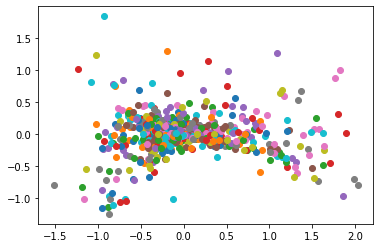

In [273]:
visualize_data2d(random.choices(model.item_factors, k=1000))

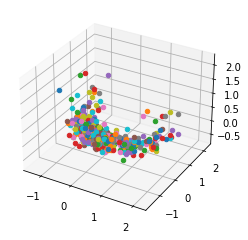

In [262]:
visualize_data3d(random.choices(model.item_factors, k=1000))

(1000,) (1000,)


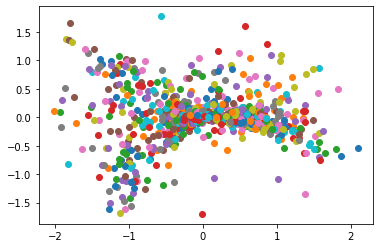

In [263]:
visualize_data2d(random.choices(model.user_factors, k=1000))

In [264]:
model.item_factors.shape

(624900, 129)

In [265]:
documents = df.drop_duplicates(subset=['doc_id'])
documents.shape

(624900, 16)

In [271]:
def get_similar(item_id, n_similar=5):
    similar = model.similar_items(item_id, n_similar)
    similar = pd.DataFrame(similar, columns=["iid", "similarity"])
    similar["doc_id"] = similar["iid"].map(back_doc_mapping).fillna(-1).apply(int)
    
    similar = similar \
        .merge(documents, on='doc_id', how='left')
    
    return similar


In [267]:
documents.title = documents.title.fillna("")

/Users/timothyxp/env/lib/python3.8/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [268]:
documents["iid"] = documents["doc_id"].map(doc_mapping)

<ipython-input-268-79af6026f772>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["iid"] = documents["doc_id"].map(doc_mapping)


In [269]:
documents[documents.title.str.contains('От')]

,reader,inventary_id,barcode,datetime_start,datetime_end,doc_id,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id,iid
521,288,03:0000016868,381001420517,2018-04-17 15:00:00,2018-04-24 15:00:00,14661,Тургенев Иван Сергеевич,Отцы и дети,Москва,Детская литература,2013,Школьная библиотека,Художественная литература,84(2Рос)1,None,03:0000016868,72
625,302,03:0000012958,381001625714,2018-04-17 15:00:00,2018-05-11 15:00:00,11503,None,"Отель, портье и три ноги под кроватью",Москва,АСТ,2013,None,Художественная литература,84(7Сое),None,03:0000012958,91
1330,391,03:0000024121,381000771474,2018-04-19 15:00:00,2018-05-08 15:00:00,20369,Устинова Татьяна Витальевна,От первого до последнего слова,Москва,Эксмо,2007,None,Художественная литература,84(2Рос)6,None,03:0000024121,216
3857,543,03:0000008359,381001624892,2018-04-20 15:00:00,2018-05-20 15:00:00,415,Касс Кира,Отбор,Санкт-Петербург,Азбука ; Азбука-Аттикус,2014,Lady Fantasy,Художественная литература,84(7Сое),None,03:0000008359,546
4016,580,03:0000019346,381001196665,2018-04-21 15:00:00,2018-06-08 15:00:00,7228,Берсенева Анна,Ответный темперамент,Москва,Эксмо,2010,Романы Анны Берсеневой,Художественная литература,84(2Рос)6,None,03:0000019346,572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10325197,556628,21:0000011010,2181000412074,2020-10-29 15:00:00,2020-10-29 15:00:00,776874,Максакова Лидия Владимировна,Культура Советской России в годы Великой Отече...,Москва,Наука,1977,None,История России,63.3(2)622,None,21:0000011010,624459
10325198,556628,21:0000011009,2181000412067,2020-10-29 15:00:00,2020-10-29 15:00:00,232178,None,Ленинский комсомол в Великой Отечественной войне,Москва,Молодая гвардия,1975,None,Общественные движения и организации,66.7 ; 66.75(2),None,21:0000011009,624460
10326252,564979,05:0000901508,580010464288,2020-10-29 15:00:00,2020-10-29 15:00:00,1435531,Орлов Геннадий Владимирович,Отечественная история. Мир и россияне : 1861-2001,Москва,Вузовская книга,2003,None,История России,63.3(2)я73,None,05:0000901508,624605
10326594,287676,05:0000208235,580003264253,2020-10-29 15:00:00,2020-11-28 15:00:00,950070,Бальзак Оноре де,Отец Горио; Гобсек; Неведомый шедевр; Полковни...,Москва,Московский рабочий,1973,Школьная библиотека,Художественная литература,84(4Фра),None,05:0000208235,624652


In [384]:
documents.shape

(624900, 17)

In [272]:
get_similar(72, 30)

,iid_x,similarity,doc_id,reader,inventary_id,barcode,datetime_start,datetime_end,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id,iid_y
0,72,1.000000,14661,288,03:0000016868,381001420517,2018-04-17 15:00:00,2018-04-24 15:00:00,Тургенев Иван Сергеевич,Отцы и дети,Москва,Детская литература,2013,Школьная библиотека,Художественная литература,84(2Рос)1,None,03:0000016868,72
1,18066,0.910006,588557,11620,03:0000380879,381012936892,2018-08-29 15:00:00,2018-09-19 15:00:00,Тургенев Иван Сергеевич,Сочинения,Самара,Самарский Дом печати,1995,None,Художественная литература,84(2Рос)1,None,03:0000380879,18066
2,9653,0.854463,5166,5495,03:0000219297,381001980707,2018-06-29 15:00:00,2018-08-29 15:00:00,Пушкин Александр Сергеевич,Избранное,Москва,Детская литература,1976,Библиотека мировой литературы для детей,Художественная литература,84(2Рос)1,None,03:0000219297,9653
3,124441,0.830915,363985,67673,03:0000128773,381004985464,2019-01-25 15:00:00,2019-02-14 15:00:00,Лермонтов Михаил Юрьевич,Собрание сочинений,Москва,Правда,1969,"Библиотека ""Огонек""",None,None,None,03:0000128773,124441
4,9889,0.827192,677458,3676,03:0000225561,381000469715,2018-07-01 15:00:00,2018-07-03 15:00:00,Лесков Николай Семенович,Повести и рассказы,Москва,Детская литература,1982,Школьная библиотека,Художественная литература,84(2Рос=Рус)1,None,03:0000225561,9889
5,28829,0.826118,742797,13027,03:0000126646,381004983262,2018-10-03 15:00:00,2018-11-03 15:00:00,Гончаров Иван Александрович,Обломов,Москва,Советская Россия,1982,Школьная библиотека,Художественная литература,84(2Рос=Рус)1,None,03:0000126646,28829
6,30102,0.814567,60839,21002,03:0000158402,381005474677,2018-10-05 15:00:00,2018-11-07 15:00:00,Гончаров Иван Александрович,Обломов,Москва,Художественная литература,1982,Библиотека классики. Русская литература,Художественная литература,84(2Рос)1,None,03:0000158402,30102
7,116275,0.810019,511559,58004,03:0000710677,381009311053,2019-01-17 15:00:00,2019-02-06 15:00:00,Лермонтов Михаил Юрьевич,Сочинения,Москва,Правда,1988,None,Художественная литература,84,None,03:0000710677,116275
8,1924,0.806738,543982,1425,03:0000048803,381001051872,2018-05-10 15:00:00,2018-06-09 15:00:00,Лесков Николай Семенович,Леди Макбет Мценского уезда,Москва,ЭКСМО-Пресс,1999,Русская классика,Художественная литература,84(2Рос=Рус)1,None,03:0000048803,1924
9,9343,0.806702,197524,892,03:0000069529,381000674881,2018-06-27 15:00:00,2018-07-04 15:00:00,Лесков Николай Семенович,,None,None,1995,Новая школьная библиотека,Художественная литература,84(2Рос)1,None,03:0000069529,9343


In [397]:
top_documents = df \
    .groupby("doc_id") \
    [["reader"]] \
    .count() \
    .rename(columns={"reader": "doc_freq"}) \
    .sort_values(by=["doc_freq"], ascending=False) \
    [:50_000]

top_documents.to_parquet("server/data/top_documents.parquet")

In [400]:
top_documents = documents[documents.doc_id.isin(top_documents.index)]

In [402]:
top_documents.to_parquet("server/data/top_documents.parquet")

In [396]:
top_documents

doc_freq    40
Name: 892955, dtype: int64

In [398]:
documents.to_parquet("server/data/all_documents.parquet")

In [277]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors()

In [329]:
knn_model = knn_model.fit(model.item_factors)

In [299]:
model.item_factors[:, :128].shape

(624900, 128)

In [330]:
def get_knn_by_history(history, n_neighbors=5):
    history = list(map(doc_mapping.get, history))
    user_vector = np.mean(model.item_factors[history], axis=0)
    
    print(user_vector.shape)
    knn_result = knn_model.kneighbors(user_vector.reshape(1, -1), n_neighbors=n_neighbors)[1].flatten().tolist()
    
    return list(map(back_doc_mapping.get, knn_result))

In [331]:
def get_book_info(doc_ids):
    return documents[documents.doc_id.isin(doc_ids)]

In [377]:
import joblib

In [378]:
%load_ext autoreload

In [379]:
%autoreload 2
from server.src.models import RecModel

SyntaxError: invalid syntax (models.py, line 12)

In [380]:
joblib.dump(
    (user_mapping, doc_mapping, back_user_mapping, back_doc_mapping),
    "server/data/mappers.pkl"
)

['server/data/mappers.pkl']

In [381]:
joblib.dump(model, "server/data/model.pkl")

['server/data/model.pkl']

In [383]:
joblib.dump(sparse_item_user, "server/data/item_user_data.pkl")

['server/data/item_user_data.pkl']

In [ ]:
model.recalculate_user(2, )

In [339]:
user_ids

[163,
 164,
 165,
 168,
 170,
 171,
 173,
 174,
 176,
 177,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 193,
 198,
 199,
 202,
 203,
 204,
 205,
 206,
 207,
 211,
 212,
 213,
 214,
 217,
 218,
 219,
 221,
 222,
 224,
 226,
 228,
 230,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 278,
 279,
 280,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 315,
 316,
 317,
 318,
 321,
 322,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366

In [369]:
ex_df = df[df.reader == 242]

In [370]:
ex_df

,reader,inventary_id,barcode,datetime_start,datetime_end,doc_id,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id
99,242,03:0000012127,381000277815,2018-04-17 15:00:00,2018-04-17 15:00:00,9697,Кэмерон Брюс,Хозяин собаки,Москва,Эксмо,2017,"Тот, кто не предаст. Люди и их питомцы",Художественная литература,84(7Сое),16+,03:0000012127
23804,242,03:0000095543,381000245913,2020-01-15 15:00:00,2020-01-15 15:00:00,57777,Абгарян Наринэ Юрьевна,С неба упали три яблока,Москва,АСТ,2016,None,Художественная литература,84(2Рос)6,16+,03:0000095543
32364,242,03:0000002575,381000118231,2019-11-07 15:00:00,2019-11-08 15:00:00,2389,Пушкин Александр Сергеевич,Сказка о мертвой царевне и о семи богатырях,Москва,Издательство имени Сабашниковых,2000,None,Литература для детей и юношества ; Художествен...,84(2Рос)1,None,03:0000002575
32983,242,03:0000002259,381000325110,2019-05-26 15:00:00,2019-07-26 15:00:00,2114,Куприн Александр Иванович,Белый пудель,Москва,Детская литература,2002,Школьная библиотека,Художественная литература,84(2Рос)6,None,03:0000002259
32984,242,03:0000002259,381000325110,2019-07-26 15:00:00,2019-08-17 15:00:00,2114,Куприн Александр Иванович,Белый пудель,Москва,Детская литература,2002,Школьная библиотека,Художественная литература,84(2Рос)6,None,03:0000002259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964383,242,Б03:00086792,381024992732,2020-09-05 15:00:00,2020-09-22 15:00:00,1553002,None,Домашний очаг,None,None,2020,None,Издания универсального содержания,95,16+,Б03:00086792
9964384,242,Б03:00087179,381024997560,2020-09-05 15:00:00,2020-09-22 15:00:00,1553021,None,Здоровье,None,None,2020,None,Здравоохранение и медицина,5,16+,Б03:00087179
10019651,242,03:0000122319,381000250016,2020-09-11 15:00:00,2020-09-29 15:00:00,360150,Березин Антон Игоревич,"История с деньгами, или Детям до 16 путешество...",Москва,Эксмо,2010,"Другой, другие, о других. Детский проект Л. Ул...",Финансы. Банковское дело. Рынок ценных бумаг. ...,65.26 ; 63.2,None,03:0000122319
10019652,242,03:0000122319,381000250016,2020-09-11 15:00:00,2020-10-29 15:00:00,360150,Березин Антон Игоревич,"История с деньгами, или Детям до 16 путешество...",Москва,Эксмо,2010,"Другой, другие, о других. Детский проект Л. Ул...",Финансы. Банковское дело. Рынок ценных бумаг. ...,65.26 ; 63.2,None,03:0000122319


In [375]:
recs = model.recommend(user_mapping[242], sparse_item_user.T, N=5)

In [376]:
get_book_info([back_doc_mapping[iid] for iid, pred in recs])

,reader,inventary_id,barcode,datetime_start,datetime_end,doc_id,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id,iid
41535,3001,03:0000099914,381003872222,2018-06-03 15:00:00,2018-06-13 15:00:00,2496,Тургенев Иван Сергеевич,Отцы и дети,Москва,Детская литература,2001,None,Художественная литература,84(2Рос)1,None,03:0000099914,5230
70473,2552,03:0000058059,381001454383,2018-06-24 15:00:00,2018-07-10 15:00:00,520285,Зощенко Михаил Михайлович,Избранное,Москва,Правда,1981,None,Художественная литература,84(2Рос=Рус)6,None,03:0000058059,8790
109460,8164,03:0000282313,381003851517,2018-07-25 15:00:00,2018-08-02 15:00:00,1001569,Ремарк Эрих Мария,Жизнь взаймы,Москва,АСТ,2014,Возвращение с Западного фронта,Художественная литература,84,None,03:0000282313,13491
4035198,35896,10:0000284362,1000002843628,2019-08-28 15:00:00,2020-01-14 15:00:00,1187845,Петрановская Людмила Владимировна,Если с ребенком трудно,Москва,АСТ,2019,Библиотека Петрановской ; Вопрос-ответ (Близки...,Психология труда и профессиональной деятельности,88.8,12+,10:0000284362,283738
9290227,282686,Б11:00005550,1180001056363,2020-07-08 15:00:00,2020-07-08 15:00:00,1281958,None,Женское здоровье,None,None,2020,None,Здравоохранение и медицина,5,16+,Б11:00005550,538961


In [374]:
get_book_info( get_knn_by_history(ex_df.doc_id.tolist()))

(129,)


,reader,inventary_id,barcode,datetime_start,datetime_end,doc_id,author,title,p260a,p260b,p260c,p490a,topic,p084a,book_age,inventory_id,iid
4794523,273494,06:0000020228,680003412668,2019-10-03 15:00:00,2019-10-03 15:00:00,1002678,Моторов Алексей,Юные годы метбрата Паровозова,Москва,АСТ,2012,None,Художественная литература,84(2рос=рус)6,None,06:0000020228,323563
5410752,121464,08:0000254667,880003208692,2019-10-31 15:00:00,2019-10-31 15:00:00,1088793,Голубинцева Елена Алексеевна,Подарки из кожи,Москва ; Санкт-Петербург,Эксмо ; Валери СПД,2002,"Академия ""Умелые руки""",Рукоделие,37.248,None,08:0000254667,354425
6331141,280627,11:0000068453,1180001178720,2019-12-08 15:00:00,2019-12-12 15:00:00,1274961,Бережкова Людмила Васильевна,Головная боль,Санкт-Петербург,Нева,2005,None,Невропатология. Нейрохирургия,56.12,None,11:0000068453,396140
9423729,228828,06:0000024545,680003406452,2020-07-16 15:00:00,2020-07-16 15:00:00,1005084,None,Живое питание по методу легендарного диетолога...,Москва,Эксмо,2013,None,Мистика. Магия. Эзотерика и оккультизм,86.42 ; 36.99,None,06:0000024545,545836
9999880,290514,Б11:00006372,1180001177440,2020-09-10 15:00:00,2020-09-10 15:00:00,1556457,None,Сельская новь,None,None,2020,None,Издания универсального содержания,95,12+,Б11:00006372,587158


In [ ]:
user_item_matrix = coo_matrix()